The Cross-entropy method (CEM) is a technique for rare event simulation that can also used for solving black-box function optimization. A black box optimization technique allows us to find a function's extremum (minima or maxima) without computing gradients. It is useful when computing gradients is costly or not possible. Moreover, since it is a global technique, it is theoretically guaranteed to converge to a global optimum, although, as we will see, it might not be the case in practice.

Our tutorial is adapted from the @deboer05tutorial, @rubinstein04crossentropy, @botev13crossentropy and @bhattacharyya21demystifying.

## Rare-event Probability Estimation

Before looking at function optimization, we will dive into another mathematical problem of rare event probability estimate. This problem allows us to motivate and derive the CEM method, which can be extended later to optimization by viewing optimization as a rare event simulation problem. Rare event simulation is necessary to estimate the rare-event probability of non-trivial probability distributions.

Rare-event probability estimation is a useful problem in itself. For example, estimating the probability of ruin if you have a model or simulation of an insurance company is a rare-event estimation problem.

Consider the case of a random variable $X$ with a probability density function $f(x; u)$ parameterized by $u$. Now if there is a function $S(X)$ such that we define $\forall x; S(x) \ge \gamma$ as rare events, then the rare event probability l

$$
\begin{align}
l &:= P(S(X) \ge \gamma) 
  &= \int \mathcal{1}_{\{S(x) \ge \gamma\}} f(x; u)dx 
\end{align}
$$

So now the question is how to estimate this quantity. It is intractable to compute this as S(X) could be complicated, or you do not know the actual pdf $f$ as an analytic function, only having access to sample from it or estimate it at a given input. 

### Monte-Carlo sampling

We can convert this probability to an expectation by 

$$ 
\begin{align}
l &= \int \mathcal{1}_{\{S(x) \ge \gamma\}} f(x; u)dx \\ 
  &= \mathbb{E}_{x \sim f(.;u)}[\mathcal{1}_{\{S(x) \ge \gamma\}}] 
\end{align} 
$$

If we generate $n$ samples from the distribution, we can use Monte Carlo sampling to estimate the rare-event probability. Monte Carlo sampling involves estimating some statistics by using samples to approximate the distribution. 

$$ 
\begin{align} 
l &= \mathbb{E}_{x \sim f(.;u)}\left[\mathcal{1}_{\{S(x) \ge \gamma\}}\right] \\ 
  &\approx \dfrac{1}{n} \sum_{k=1}^{n} \mathcal{1}_{\{S(x_k) \ge \gamma\}}
\end{align} 
$$

Where $x_1 ... x_k$ are i.i.d samples from f(.; u).

Let us implement some code to see how this works. First, we will define a $f(.;u)$ as a standard normal distribution $\mathcal{N}(0, 1)$ and rare event as $X > 2$, so $S(X):= X$ is an identity function. Since it is a normal distribution, we can compute l in closed form. It is just the $1 - \text{CDF}(2)$. We picked the normal distribution for the sake of illustration; in the real world, the distribution could be something more complex, without a closed form CDF, or as noted before, you might not even know the functional form of the pdf, only can sample from it and evaluate it at a point or if S(X) is something complicated, again the integral might be intractable.

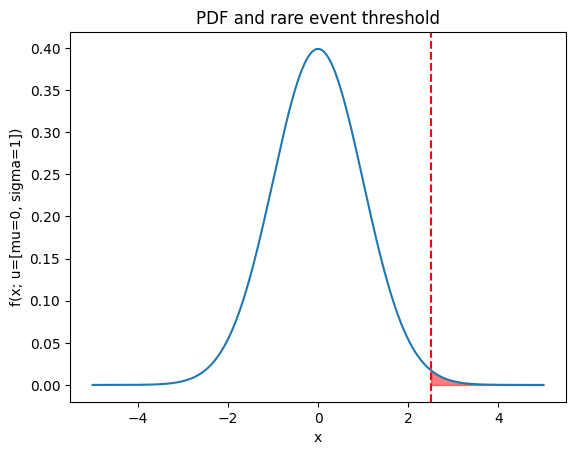

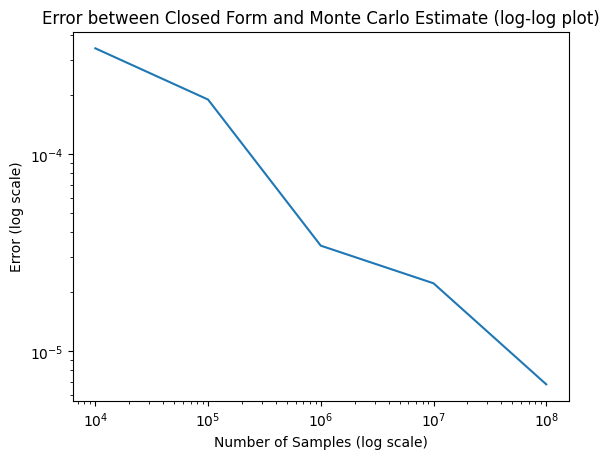

In [6]:
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.stats import norm, uniform
np.random.seed(42)

# Problem setup
def f(x, u=0):
    # Standard normal distribution PDF
    return norm.pdf(x, loc=u)

def sample_f(num_samples, u=0):
    return np.random.normal(loc=u, size=(num_samples,))

def S(x):
    # identity function
    return x

# rare event threshold (gamma)

GAMMA = 2.5

N_SEEDS = 10

# Iterative Monte Carlo
NUM_SAMPLES = np.array([10**i for i in range(4, 9)])

# Closed form solution using CDF
L_GT = 1 - norm.cdf(GAMMA)


def rare_event_indicator(x):
    return S(x) >= GAMMA

def monte_carlo_estimate(num_samples, sampler, estimand_fn):
    samples = sampler(num_samples)
    return np.mean(estimand_fn(samples))

mc_errors = []
for n in NUM_SAMPLES:
    mc_probs = []
    # Repeat the experiment for multiple seeds and report average
    for i in range(N_SEEDS):
        p = monte_carlo_estimate(n, sample_f, rare_event_indicator)
        mc_probs.append(p)
    errors = np.abs(np.array(mc_probs) - L_GT)
    mc_errors.append(np.mean(errors))

# plot the pdf and the rare event threshold and area
x = np.linspace(-5, 5, 1000)
plt.plot(x, f(x))
plt.axvline(GAMMA, color='red', linestyle='--')
plt.fill_between(x, f(x), where=S(x) > GAMMA, color='red', alpha=0.5)
plt.xlabel('x')
plt.ylabel('f(x; u=[mu=0, sigma=1])')
plt.title('PDF and rare event threshold')
plt.show()

# plot the error and std band
plt.plot(NUM_SAMPLES, mc_errors)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Samples (log scale)')
plt.ylabel('Error (log scale)')
plt.title('Error between Closed Form and Monte Carlo Estimate (log-log plot)')
plt.show()

Since sampling rare events implies we need many Monte Carlo samples to improve in error. Can we do something better?

### Importance sampling
Instead of generating samples from $f(.; u)$, what if we generate data from another distribution with p.d.f $g(x)$ where the rare samples are easier to obtain? Then, if we can compute the p.d.f of our original distribution $f(.; u)$ and our new distribution $g(x)$, we can use importance sampling to compute $l$ using these samples. 


$$ \begin{align} 
l &= \int \mathcal{1}_{\{S(x) \ge \gamma\}} f(x; u)dx \\ 
  &= \int \mathcal{1}_{\{S(x) \ge \gamma\}} f(x; u) \dfrac{g(x)}{g(x)} dx \\ 
  &= \mathbb{E}_{x \sim g(.)}\left[ \mathcal{1}_{\{S(x) \ge \gamma\}} \dfrac{f(x; u)}{g(x)} \right]
\end{align} $$

And the monte-carlo estimate now can be done over samples from $g(x)$

$$ 
\begin{align} 
l &=\mathbb{E}_{x \sim g(.)}\left[ \mathcal{1}_{\{S(x) \ge \gamma\}} \dfrac{f(x; u)}{g(x)} \right] \\ 
  &\approx \dfrac{1}{n} \sum_{k=1}^{n} \mathcal{1}_{\{S(x_k) \ge \gamma\}} \dfrac{f(x_k; u)}{g(x_k)}
\end{align} 
$$
Where $x_1 ... x_k$ are i.i.d samples from g(x).
Now the question becomes how do we select this $g(x)$? Let us first try a few examples of $g(x)$ and see how it compares to our previous Monte Carlo estimate.

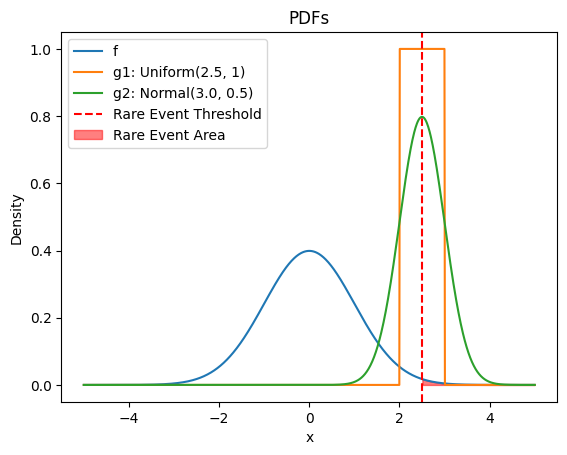

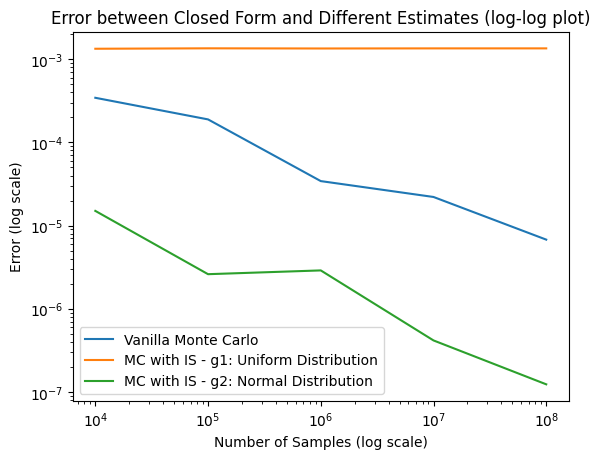

In [7]:
# Pick g1 to be uniform distribution near the rare event threshold and g2 to be a normal distribution near the rare event threshold
def g1_uniform(x):
    return uniform.pdf(x, loc=GAMMA - 0.5, scale=1)

def sample_g1(num_samples):
    return np.random.uniform(size=(num_samples,), low=GAMMA - 0.5, high=GAMMA + 0.5)

def g2_normal(x):
    return norm.pdf(x, loc=GAMMA, scale=0.5)

def sample_g2(num_samples):
    return np.random.normal(loc=GAMMA, scale=0.5, size=(num_samples,))


# plot f, g1, and g2 and rare event threshold
x = np.linspace(-5, 5, 1000)
plt.plot(x, f(x), label='f')
plt.plot(x, g1_uniform(x), label='g1: Uniform(2.5, 1)')
plt.plot(x, g2_normal(x), label='g2: Normal(3.0, 0.5)')
plt.axvline(GAMMA, color='red', linestyle='--', label='Rare Event Threshold')
plt.fill_between(x, f(x), where=S(x) > GAMMA, color='red', alpha=0.5, label='Rare Event Area')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('PDFs')
plt.legend()
plt.show()

# Importance Sampling
def rare_event_prob_importance_sampling(num_samples, rare_event_threshold, g, sample_g):
    x = sample_g(num_samples)
    return np.mean((S(x) >= rare_event_threshold) * f(x) / g(x)) 

# calculate the probabilities using importance sampling for g1 and g2 for the n in num_samples and plot everything in one log-log plot
g1_is_errors = []
g2_is_errors = []
for n in NUM_SAMPLES:
    g1_is_estimates = []
    for i in range(N_SEEDS):
        p = rare_event_prob_importance_sampling(n, GAMMA, g1_uniform, sample_g1)
        g1_is_estimates.append(p)
    g1_is_error = np.abs(np.mean(g1_is_estimates) - L_GT)
    g1_is_errors.append(g1_is_error)
    g2_is_estimates = []
    for i in range(N_SEEDS):
        p = rare_event_prob_importance_sampling(n, GAMMA, g2_normal, sample_g2)
        g2_is_estimates.append(p)
    g2_is_error = np.abs(np.mean(g2_is_estimates) - L_GT)
    g2_is_errors.append(g2_is_error)


# plot the order of error for importance sampling
plt.plot(NUM_SAMPLES, mc_errors, label='Vanilla Monte Carlo')
plt.plot(NUM_SAMPLES, g1_is_errors, label='MC with IS - g1: Uniform Distribution')
plt.plot(NUM_SAMPLES, g2_is_errors, label='MC with IS - g2: Normal Distribution')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Samples (log scale)')
plt.ylabel('Error (log scale)')
plt.title('Error between Closed Form and Different Estimates (log-log plot)')
plt.legend()
plt.show()

Different importance sampling distribution leads to better or worse performance compared to Monte Carlo sampling. Intuitively, if $g(x)$ puts a lot of probability mass over areas where $S(x) > \gamma$, then we can get accurate estimates faster. 

The optimal importance sampling estimator (which has zero variance) can be derived to be 

$$ 
g^*(x) = \mathcal{1}_{\{S(x) \ge \gamma\}} \dfrac{f(x; u)}{l} 
$$ {#eq-g-star}

Let us plot it to see why it is optimal.


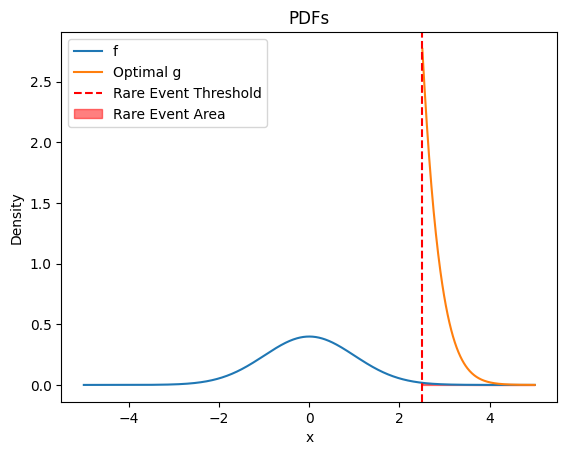

In [8]:
def optimal_g(x):
    return (S(x) >= GAMMA) * f(x) / L_GT

# plot it with f 
x = np.linspace(-5, 5, 1000)
plt.plot(x, f(x), label='f')

optimal_g_pdf = optimal_g(x)
plt.plot(x[optimal_g_pdf > 0], optimal_g_pdf[optimal_g_pdf > 0], label='Optimal g')
plt.axvline(GAMMA, color='red', linestyle='--', label='Rare Event Threshold')
plt.fill_between(x, f(x), where=S(x) > GAMMA, color='red', alpha=0.5, label='Rare Event Area')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('PDFs')
plt.legend()
plt.show()


We can see that this distribution corresponds to the region where rare samples occur, and it is proportional to the $f(x; u)$. To further convince yourself of this, plug $g*(x)$ into the importance sampling Monte Carlo estimator.

$$ 
\begin{align} 
\hat{l} &= \dfrac{1}{n} \sum_{k=1}^{n} \mathcal{1}_{\{S(x_k) \ge \gamma\}} \dfrac{f(x_k; u)}{g^*(x_k)} \\
        &= \dfrac{1}{n} \sum_{k=1}^{n} l \\
        &= l
\end{align}
$$

**But wait!** We wanted to estimate $l$, but now our optimal importance sampling distribution has l in it. However, this indicates what we want our $g(x)$ to approach. We want to find a g that's as close as possible to $g*$. Theoretically, g can be any distribution, but since we want something we want to sample from, let us restrict g(x) to the same family as the original pdf $f$. So $g(x) = f(x; v)$ with $v$ being the parameters of this distribution. We aim to optimize v so that $g(x)$ approximates $g^*(x)$ as close as possible. The closeness between two distributions can be captured by the notion of cross-entropy between distributions, i.e., $\mathcal{D} (g^*(x), f(x; v))$. 

::: {.callout-tip}
Cross-entropy is not a symmetric metric. The formulation we use tries to place probability mass on the mean of the optimal distribution.
:::

Our $g^*(x) = f (x; v)$ if the cross entropy is zero.
$$
\begin{align*}
v^{*} &= \arg\min_{v} \mathcal{D} (g^*(x), f(x; v)) \\
      &= \arg\min_{v} E [\ln f(x; v)] \\
      &= \arg\min_{v} \int g^*(x) \ln g^*(x) dx - \int g^*(x) \ln f(x; v) dx.
\end{align*}
$$

Since the $g^*(x)$ is independent of v, our minimization objective is left with 

$$
\begin{align*}
v^{*} &=  \arg\min_{v} - \int g^*(x) \ln f(x; v) dx.
\end{align*}
$$

Removing the negative sign by converting minimization to maximization and plugging in the expression for $g^*(x)$ {@eq-g-star}

$$
\begin{align*}
v^{*} &=  \arg\max_{v} \int  \mathcal{1}_{\{S(x) \ge \gamma\}} \dfrac{f(x; u)}{l} \ln f(x; v) dx.
\end{align*}
$$
Since l is independent of v, we can finally discard it. This removes the **chicken and egg** problem of knowing $l$ to estimate $l$. We now have

$$
\begin{align*}
v^{*} &=  \arg\max_{v} \int  \mathcal{1}_{\{S(x) \ge \gamma\}} f(x; u) \ln f(x; v) dx,\\
      &=  \arg\max_{v} E_{x \sim f(.;u)} [\mathcal{1}_{\{S(x) \ge \gamma\}}  \ln f(x; v)] ,
\end{align*}
$$


Now, we have a maximization problem to find the parameters of the importance sampling density function closest to the optimal one. This expectation is now the same as finding the maximum likelihood estimate of the parameter $v$ for rare data samples ($S(x) \ge \gamma$). It has a closed-form solution for distributions in the natural exponential family. But we are not done yet; the maximum likelihood is over rare samples!
If we naively sample from $f(.; u)$, we need lots of samples for at least some indicators $S(x) \ge \gamma$ to be one and hence allowing maximization of v. It Seems like we end up where we started with monte-carlo. However, it turns out that we can do something better with this objective.

First, we introduce $w$, a reference parameter, and apply the same trick used in importance sampling to switch expectations to samples under distribution parameterized by $w$ instead of $u$. The reason why we introduce this parameter will become apparent next.

$$
\begin{align*}
v^{*} &= \arg\max_{v} E_{x \sim f(.;u)} [\mathcal{1}_{\{S(x) \ge \gamma\}}  \ln f(x; v)] , \\
      &= \arg\max_{v} E_{x \sim f(.;w)} [\mathcal{1}_{\{S(x) \ge \gamma\}} \dfrac{f(x; u)}{f(x; w)} \ln f(x; v)] , \\
      &= \arg\max_{v} E_{x \sim f(.;w)} [\mathcal{1}_{\{S(x) \ge \gamma\}} \dfrac{f(x; u)}{f(x; w)} \ln f(x; v)] ,
\end{align*}
$$

Our problem was $S(x) > \gamma$ is rare; instead of trying to solve for this, we make the problem easier by constructing a sequence of threshold of rare event thresholds $\{ \gamma_t \}$ and reference parameters $\{v_t\}$ to converge to $\gamma^*, v^*$. At each iteration $t$ we sample $x_1, ... x_n$ from the current importance sampling density $f(., v_t)$ and let $\gamma_t$ be the $(1 - \rho)$ quantile value of the set $S(x_1),...,S(x_n)$, where $\rho$ is a hyperparameter also known as *rarity parameter*. We then find $v_{t+1}$ by maximizing the empirical expectation,
$$
v_{t+1} = \arg\max_{v} \dfrac{1}{n} \sum_{k=1}^{n} \left[\mathcal{1}_{\{S(x_k) \ge \gamma_t\}} \dfrac{f(x_k; u)}{f(x_k; v_t)} \ln f(x_k; v)\right]
$$

This maximization yields $f(., v_{t+1})$, which minimizes the cross entropy of the optimal importance sampling distribution $g*(x)$ for the $\gamma_t$ threshold. The solution of this maximization is the maximum-likelihood solution for the "elite samples" weighted by the $\dfrac{f(x_k; u)}{f(x_k; v_t)}$ also known as the "likelihood ratio." The total elite samples $n_e = [\rho n]$, and they by construction of $\rho_t$ satisfy $S(x_i) \ge \rho_t$.

### CEM Algorithm for rare event simulation
1. Define $v_1 = u$ and set t=1. Let $n_e = \lceil \rho n \rceil$
2. Generate $n$ i.i.d samples $x_i, ... x_n$ drawn from $f(.; v_t)$. Calculate $S_i = S(x_i)$ for all i and order these from smallest to largest $S_{(1)} ... \le S_{(n)}$. Let $\gamma_t$ to be the $(1 - \rho)$-quantile; that is \gamma_t = S_{(n - n_e + 1)}. If $\gamma_t >  \gamma$, we set it to the original problem value, i.e., $\gamma_t = \gamma$.
3. Then, with the same samples we got in (2), we solve the following maximization to obtain $v_{t+1}$
      $$
            \begin{align*}
            v_{t+1} &= \arg\max_{v} \dfrac{1}{n} \sum_{k=1}^{n} \left[\mathcal{1}_{\{S(x_k) \ge \gamma_t\}} \dfrac{f(x_k; u)}{f(x_k; v_t)} \ln f(x_k; v)\right] , \\
            \end{align*}
      $$

4. **If** $\gamma_t < \gamma$ and $ t < \text{max\_iterations} $,
       set $t = t+1$ and reiterate from step 2. 
    **Else**, 
       continue to step 5.
5.  Sample $x_1, x_2, ... x_{n'}$ from $f(.; v_T)$, where $t=T$ is the total iterations our algorithm ran. Estimate the rare-event probability $l$ using importance sampling $l = \approx \dfrac{1}{n'} \sum_{k=1}^{n'} \mathcal{1}_{\{S(x_k) \ge \gamma\}} \dfrac{f(x_k; u)}{f(x_k; v_T)}$.



For distributions that belong to a natural exponential family, the maximization at (3) has the following closed-form solution for v being the mean parameter of the distribution.

$$
v_{t+1} = \dfrac{\sum_{k=1}^{n} \mathcal{1}_{\{S(x_k) \ge \gamma_t\} W(x_i; u, v_t) x_i}}{\mathcal{1}_{\{S(x_k) \ge \gamma_t\} W(x_i; u, v_t)}}
$$

where $W(x_i; u, v_t) = \dfrac{f(x_i; u)}{f(x_i; v_t)}$ is the likelihood ratio. To derive this solution, compute the derivative w.r.t $v$ and set it to zero.

Now, with this setup, let us jump into the code.

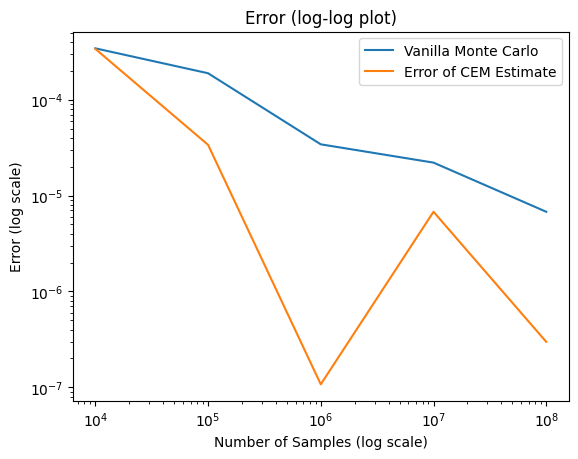

In [9]:

def cem_rare_event_estimate(n, max_sample_n, u=0, rho=0.01):
    t = 0
    v_t = u
    gamma_t = None
    n_e = int(np.ceil(n * rho))
    max_iter = max_sample_n // n
    while t < max_iter - 1:
        samples = sample_f(n)
        s = S(samples)
        # compute the quantile of the samples
        sort_idx = np.argsort(s)
        sorted_s = s[sort_idx]
        gamma_t = sorted_s[-n_e]
        if gamma_t > GAMMA:
            gamma_t = GAMMA
        elite_samples = samples[sort_idx][-n_e:]
        weights = f(elite_samples, u) / f(elite_samples, v_t)
        # maximize the cross entropy objective to get the next v_t.
        # Here we use the closed form solution for the normal distribution
        v_t = np.sum(weights * elite_samples) / np.sum(weights)
        t += 1
        if gamma_t == GAMMA:
            break
    
    actual_sample_n = t * n
    remaining_samples = max_sample_n - actual_sample_n
    estimate = rare_event_prob_importance_sampling(remaining_samples, GAMMA, lambda x: f(x, v_t), lambda n: sample_f(n, v_t))
    return estimate


cem_errors = []
for n in NUM_SAMPLES:
    max_samples = n
    estimates = []
    for _ in range(N_SEEDS):
        
        estimate = cem_rare_event_estimate(max_samples // 10, max_samples)
        estimates.append(estimate)
    cem_errors.append(np.abs(np.mean(estimates) - L_GT))


# plot the order of error for importance sampling
plt.plot(NUM_SAMPLES, mc_errors, label='Vanilla Monte Carlo')
plt.plot(NUM_SAMPLES, cem_errors, label='Error of CEM Estimate')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Samples (log scale)')
plt.ylabel('Error (log scale)')
plt.title('Error (log-log plot)')
plt.legend()
plt.show()


We see orders of magnitude improvement in the error using CEM compared to the naive Monte Carlo method for the same number of samples. We can get even better if we carefully tune the hyperparameters of the number of maximum iterations, samples per iteration, the number of samples to use for the final importance sampling, and the rarity parameter $rho$.


## Function optimization

While rare event probability has real-world uses, function optimization is a more common problem. Say you want to find the maximum of $S(x)$ over a given set $\mathcal{X}$. For simplicity, assume that there is only one maximum. Then,

$$
S(x^*) = \gamma^* = \max_{x \in \mathcal{X}} S(x)
$$

For some arbitrary distribution $f(x)$ over $\mathcal{X}$, since the maximum is rare, we can associate the maximization with the problem of estimating $l = P_f(S(x) \ge \gamma)$. The difference with rare event estimation is that we do not have $\gamma$, and we only care about finding $\gamma_*$ and not $l$ for our arbitrary initial distribution $f$. However, from our prior algorithm for rare event estimation, we now have a method to get monotonically better $gamma_t$ (there are some proofs for this I do not know and am glossing over). We can modify the rare event estimation algorithm in three important ways, 

1. We can set $u$ to $v_t$ in each step. This implies we are trying to estimate optimal importance sampling distribution concerning the previous step parameter $v_t$ and not $u$. This makes the likeihood ratio $f(x; u)/f(x; v_t) = 1$.
2. Since we only care about $\gamma^*$ we do not have to compute the [step 4](#cem-algorithm-for-rare-event-simulation).
3. Finally, since we do not have the actual $\gamma^*$, we must define some stopping criterion. It could be checking if $\gamma_t$ in some $c$ steps have the same or close enough values.

::: {.callout-warning}
Some references assume f(x) to be uniform. I do not understand how to have a uniform distribution if $x \in [-\inf, \inf]$.
:::


### CEM algorithm for optimization

1. Define $v_1 = u$ where $u$ is some arbitrary initial parameter and set t=1. Let $n_e = \lceil \rho n \rceil$. 
2. Generate $n$ i.i.d samples $x_i, ... x_n$ drawn from $f(.; v_t)$. Calculate $S_i = S(x_i)$ for all i and order these from smallest to largest $S_{(1)} ... \le S_{(n)}$. Let $\gamma_t$ to be the $(1 - \rho)$-quantile; that is $\gamma_t = S_{(n - n_e + 1)}$.
3. Then, with the same samples we got in (2), we solve the following maximization to obtain $v_{t+1}$ 
      $$
            \begin{align*}
            v_{t+1} &= \arg\max_{v} \dfrac{1}{n} \sum_{k=1}^{n} \left[\mathcal{1}_{\{S(x_k) \ge \gamma_t\}} \ln f(x_k; v)\right] , \\
            \end{align*}
      $$

4. **If** stopping criterion is not met **and** $t < \text{maxiterations} $;
      Set $t = t+1$ and reiterate from step 2. 
    **Else**;
      Stop.


::: {.callout-note}
An alternative heuristic is to update $v_{t+1}$ in step 3 with an exponential moving average instead of a simple replacement. $v_{t+1} = (1 - \alpha) v_t + \alpha v_{\text{new}}$
:::

In practice, we pick f as a normal distribution for optimizing functions on a continuous domain. Moreover, in this case, we can pick both mean and standard deviation as the parameters of the distribution family. i.e., $v_t = [\mu, \sigma]$. The maximization of step 3 is just the MLE estimate of elites, which is simply the mean and standard deviation for the elite samples for our normal distribution. Now, let us dive into the code to implement CEM and optimize the Rastrigin function, a highly nonlinear function with many local minima.

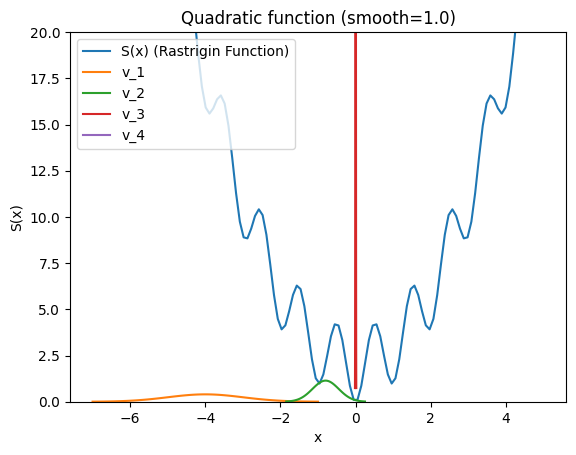

Solution is 1.0823134976106763e-05


In [11]:
np.random.seed(42) # CEM doesn't converge always, so this is the best case scenario, in practice you have to tune the hyperparameters


# # Define the Rastrigin 1d function which has lots of local minima
def S_rastrigin(x, A=2):
    return A + x**2 - A * np.cos(2 * np.pi * x)

# Define the Cross-Entropy Method (CEM)
def cem(f, u, num_samples, rho, max_iterations):
    num_elites = int(math.ceil(rho * num_samples))
    v_t = u  # mean & std
    gamma_t = None
    history_v = [v_t]
    for _ in range(max_iterations):
        # We simply use max_iterations iterations here, but in practice we can also check if the mean and std have converged
        mean_t, std_t = v_t
        samples = np.random.normal(mean_t, std_t, num_samples)
        # -f(x) because we want to minimize the function
        scores = np.array([-f(x) for x in samples])
        sorted_idx = np.argsort(scores)
        elite_idx = sorted_idx[-num_elites:]
        gamma_t = samples[elite_idx[0]]
        elites = samples[elite_idx]
        # The MLE of the elites is the closed-form solution for the cross-entropy objective for the normal distribution
        v_t = np.array([
            np.mean(elites, axis=0), 
            np.std(elites, axis=0),
        ])
        history_v.append(v_t)
    # In practise we might not coverge to a gamma_* in the  given number of iterations, so we can use the mean v_t[0] as the solution instead of gamma_t
    solution = v_t[0]
    
    return gamma_t, history_v

def plot_optimization(smooth=1.0):
    # Run the functions
    solution, v_t_history = cem(S_rastrigin, np.array([-4, 1]), 10000, 0.001, 3)
    x = np.linspace(-5, 5, 100)
    y = S_rastrigin(x)

    plt.plot(x, y, label='S(x) (Rastrigin Function)')
    
    for t, v_t in enumerate(v_t_history):
        mean, std = v_t
        # Generate data for the x axis
        x = np.linspace(mean - 3*std, mean + 3*std, 100)

        # Generate data for the y axis
        y = norm.pdf(x, mean, std)
        # Plot the normal distribution curve
        plt.plot(x, y, label=f"v_{t+1}")

    plt.legend()
    plt.xlabel('x')
    plt.ylabel('S(x)')
    plt.title(f'Quadratic function (smooth={smooth})')
    plt.ylim(0, 20)
    plt.show()
    print(f"Solution is {solution}")

plot_optimization()

The above example illustrates how we can converge to the global minimum in black-box optimization with CEM.


# Discrete or combinatorial optimization with CEM
We saw an example of applying CEM to optimize continuous parameters. It can also be applied to discrete settings. @botev13crossentropy  highlights a few examples of applying CEM to discrete optimization, such as the Knapsack packing problem, boolean satisfiability problem, and network planning problem.

# Planning with CEM
Consider the reinforcement learning setting where we want a policy that maximizes rewards (or conversely minimizes some cost in optimal control setting) in an environment.

![RL Environment - @Sutton1998](rl.png)


A policy comprises actions. Assume we have a simulator or even a learned model of the environment, which can predict the next state $P(S'|S, A) and the reward function $R(S, A)$ given the current state and action. Then, we can directly aim to optimize the set of actions that maximizes the rewards for a given horizon $H$. 
$$
\begin{equation}
\arg\max_{a_k, ... a_{k+H}} \sum_{t=k}^{k+H} R(s_t, a_t)
\end{equation}
$$


Where starting from some arbirtary state (usually the current state) $s_k$ we can rollout future states $s_k ... s_{k+H}$ using the model, either sampling the next state or using the mode of the distribution if the next state is stochastic. Then, we compute the rewards and maximize them.

We can apply CEM here on the trajectory $a_1... a_k$ to solve this problem.

Since our model of the environment might be imperfect, the common practice is only to act the first action $a_k$ in the real environment and then re-solve the same problem from the real s_{k+1}. This is known as model predictive control (MPC).

Some relevant works in MbRL using CEM for planning are @hafner2018learning, @ChuaCML18, @HansenSW22.


::: {.callout-note}
The above formulation does not yield an optimal trajectory even for a perfect model, as we do not consider the whole horizon till episode termination. If we learn an optimal value function V(S) along with the CEM policy, we can compute the final cost by using it. i.e., maximize $\arg\max_{a_k, ... a_{k+H}} \sum_{t=k}^{k+H} R(s_t, a_t) + V(s_{k+H+1})$ where we rely on the model being more accurate than the value for some steps. @HansenSW22 does this precisely.
:::

### When is CEM appropriate in MbRL?

In modern deep MbRL, we usually learn a model that is based on a neural network. In this case, instead of CEM, we can consider optimizing actions based on gradients instead of black-box CEM, as we can compute the gradients of the rewards concerning the actions. But this is tricky as models parameterized by neural nets could have a non-convex optimization landscape, directly optimizing actions could get stuck in local minima. This is usually used to motivate using black-box approach such as CEM for planning. But note that there are new works [@v2023gradientbased] pointing to efficiency of pure-gradient based optimization even for complex models.


And there is another issue, if the model is stochastic, we can only estimate an approximation of the gradient through the sampling step $s_{t+1} \sim p(s_{t+1}| s_t, a_t)$. This can make our gradient based optimization in-exact. But I do not know if this is as big of an issue as getting stuck in local minima to motiviate using black box approach such as CEM. 

One hybrid approach is @huang2021cemgd. They formulate a simple method to combine CEM with gradient-based optimization for planning. They initially used CEM for some steps to explore the optimization landscape more "globally" than the first-order gradients and then used gradient descent to converge quickly to some optima. 


# Conclusion

We dived into the CEM algorithm for rare-event probability estimation and applied it to black-box function optimization. CEM has been used in model-based RL to optimize the trajectory of actions that lead to the best predicted summed reward under the model. 


# Acknowledgments
This work was partly made possible by funding the Konrad Zuse School of Excellence in Learning and Intelligent Systems (ELIZA) grant.